In [1]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
# weekly vaccination data
vac <- read.csv("https://opendata.ecdc.europa.eu/covid19/vaccine_tracker/csv/data.csv", na.strings = "", fileEncoding = "UTF-8-BOM")
# daily incidence table
ill <- read.csv("https://opendata.ecdc.europa.eu/covid19/nationalcasedeath_eueea_daily_ei/csv", na.strings = "", fileEncoding = "UTF-8-BOM")

In [3]:
# creating the week of the year column for the daily dataset
ill$YearWeekISO <- paste(ill$year, rep('-W', nrow(ill)), strftime(ill$dateRep, '%V'), sep='')

ill %<>% as_tibble() %>% 
    select(cases, geoId, YearWeekISO, popData2020) %>% 
    mutate(cases_pop = cases / popData2020) %>% 
    select(YearWeekISO, geoId, cases_pop) %>% 
    group_by(YearWeekISO, geoId) %>% 
    summarise(sum=sum(cases_pop)) %>% 
    filter(YearWeekISO > sort(ill$YearWeekISO)[2] & YearWeekISO < max(ill$YearWeekISO) )

vac %<>% 
  rename(geoId = ReportingCountry) %>%
  filter(TargetGroup == 'ALL') %>%
  mutate(firstdose_pop = FirstDose / Population) %>%
  group_by(YearWeekISO, geoId) %>%
  summarise(firstdose_pop=sum(firstdose_pop)) %>%
  select(YearWeekISO, geoId, firstdose_pop)

#combining both dateset by the week of the year and country
vac %>% inner_join(ill, by=c('YearWeekISO', 'geoId')) -> combined

`summarise()` has grouped output by 'YearWeekISO'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'YearWeekISO'. You can override using the `.groups` argument.



In [4]:
weeks <- sort(unique(combined$YearWeekISO))
countries <- unique(combined$geoId)

# making the cumulative columns for ever infected and ever vaccinated
combined$firstdose_pop_cum = 0
combined$sum_cum = 0

for (j in countries) {
  temp_sum = 0
  temp_first = 0
  for (i in weeks) {
    combined[combined$YearWeekISO == i & combined$geoId == j, 'firstdose_pop_cum'] <- temp_first + pull(combined[combined$YearWeekISO == i & combined$geoId == j, 'firstdose_pop'])
    combined[combined$YearWeekISO == i & combined$geoId == j, 'sum_cum'] <- temp_sum + pull(combined[combined$YearWeekISO == i & combined$geoId == j, 'sum'])
    pull(combined[combined$YearWeekISO == i & combined$geoId == j, 'firstdose_pop_cum']) -> temp_first
    pull(combined[combined$YearWeekISO == i & combined$geoId == j, 'sum_cum']) -> temp_sum
  }
}

# making the column of newly infected with lag +1 for the plot
combined$sum_next <- 0

for (j in countries) {
  for (i in 1:(length(weeks)-1)) {
    combined[combined$YearWeekISO == weeks[i+1] & combined$geoId == j, 'sum_next'] <- combined[combined$YearWeekISO == weeks[i] & combined$geoId == j, 'sum']
  }
}

combined %>%
  filter(YearWeekISO != weeks[length(weeks)]) -> combined

In [5]:
# creating the column for (the odds ratio of) both never infected and never vaccinated (doesn't account for those previosly infected who got vaccinated and vice versa)
combined$regressor <- (1 - combined$sum - combined$firstdose_pop_cum) / (combined$sum + combined$firstdose_pop_cum)
# creating the column for the ratio of newly infected this week over the previous week
combined$multy <- combined$sum_next / combined$sum

# transforming the (odds) ratios into logs
combined %<>%
  filter (multy != 0 & multy != Inf & regressor != 0) %>%
  mutate(multy_log = log(multy), log_reg = log(regressor))

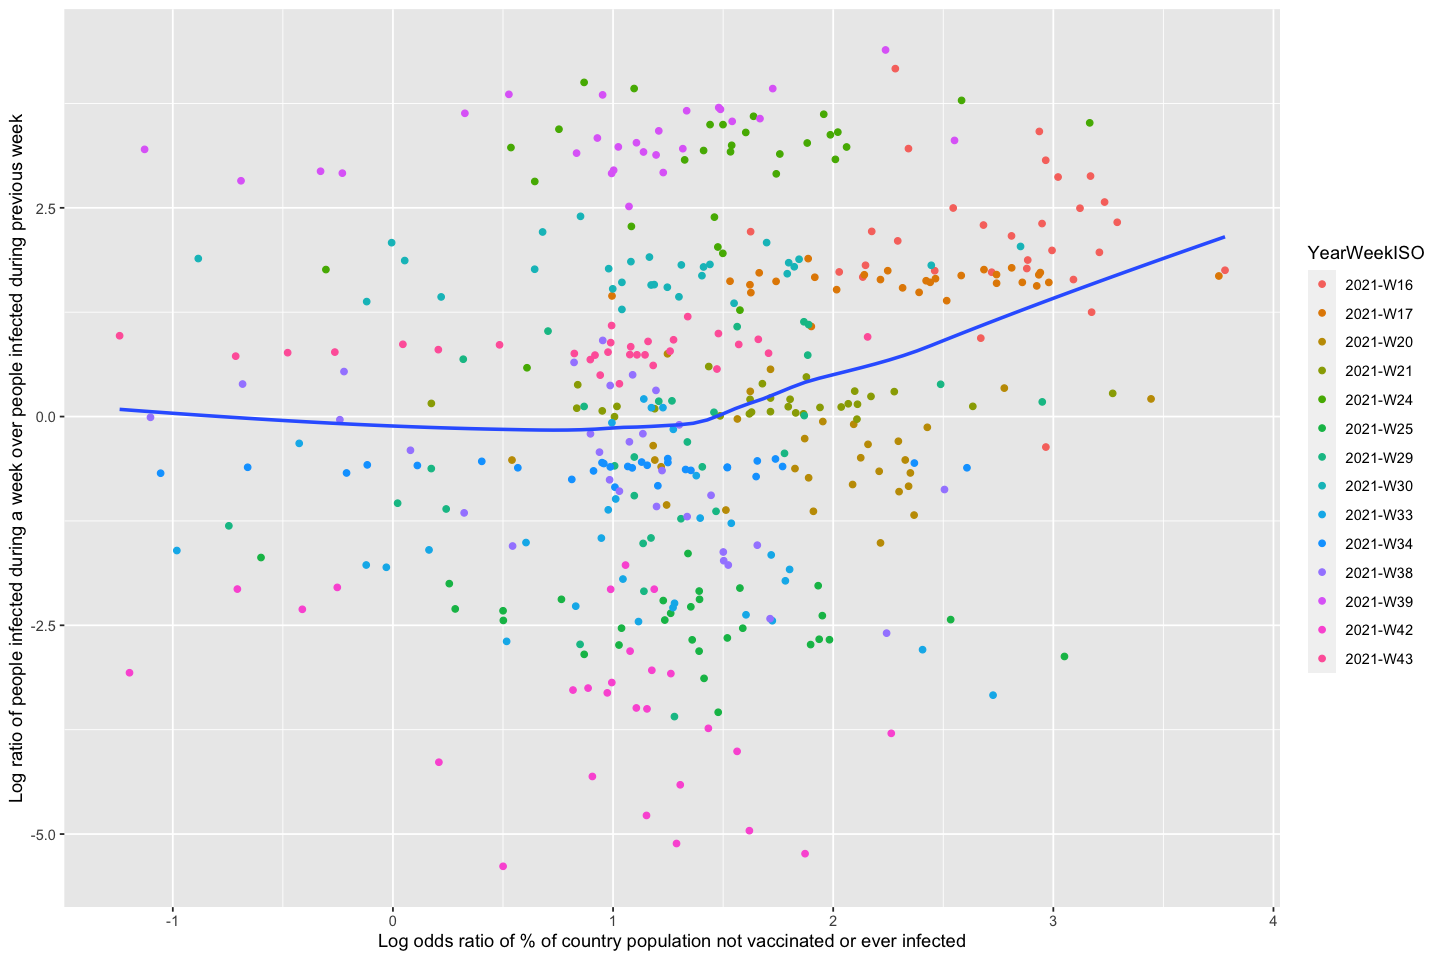

In [6]:
options(repr.plot.width=12, repr.plot.height=8)

combined %>%
  filter(multy_log < 5 & multy_log > -7.5) %>%
  ggplot(aes(x = log_reg, y = multy_log)) + 
  geom_point(aes(col=YearWeekISO)) +
  geom_smooth(method=loess, formula = y ~ x, se=F) +
  xlab("Log odds ratio of % of country population not vaccinated or ever infected") +
  ylab("Log ratio of people infected during a week over people infected during previous week")